<a href="https://colab.research.google.com/github/imAdityaSharma/GOI_hackathon_2024/blob/main/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import cudf
%load_ext cudf.pandas

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()

# Importing Train and Test data

In [4]:
df_X_train= pd.read_csv('/content/drive/MyDrive/Train_60/X_Train_Data_Input.csv',header=0)
df_Y_train = pd.read_csv('/content/drive/MyDrive/Train_60/Y_Train_Data_Target.csv',header=0)

In [5]:
df_X_test = pd.read_csv('/content/drive/MyDrive/Test_20/X_Test_Data_Input.csv',header=0)
df_Y_test = pd.read_csv('/content/drive/MyDrive/Test_20/Y_Test_Data_Target.csv',header=0)

In [6]:
# df_X_train.sample(5)

In [7]:
# df_Y_train.sample(5)

In [8]:
# df_X_test.sample(5)
# df_Y_test.sample(5)

# Data Transformation

In [9]:
# df_xy = df.join(df_Y.set_index('ID'), on='ID')
# df_xy.reset_index()

In [10]:
# remove ID
df_X_train.drop('ID',inplace=True,axis=1)
df_Y_train.drop('ID',inplace=True,axis=1)
df_X_test.drop('ID',inplace=True,axis=1)
df_Y_test.drop('ID',inplace=True,axis=1)

In [11]:
corrM_train = df_X_train.corr()
corrM_test = df_X_test.corr()
# corrM.to_csv('corrM.csv')

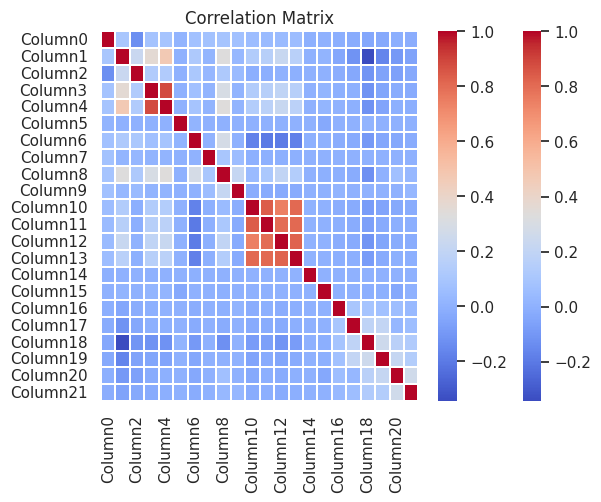

In [12]:
# plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.heatmap(corrM_train,  cmap='coolwarm', linewidths=0.2)
sns.heatmap(corrM_test,  cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Matrix')
plt.show()

In [16]:
# prompt: correlation matrix and remove dependent columns
def remove_correlated_columns(corrM, threshold=0.8):
  columns_to_drop = set()

  # Iterate over the correlation matrix
  for i in range(len(corrM.columns)):
      for j in range(i):
          if abs(corrM.iloc[i, j]) > threshold:
              colname = corrM.columns[i]
              columns_to_drop.add(colname)
  return columns_to_drop

In [17]:
# Drop the highly correlated columns from the DataFrame
df_X_train_dropped = df_X_train.drop(columns=remove_correlated_columns(corrM_train))
df_X_test_dropped = df_X_test.drop(columns=remove_correlated_columns(corrM_test))

null exploration

In [23]:
print('x_dropped \n -------------------------------------')
print(df_X_train_dropped.isnull().sum())
print('-------------------------------------\n y_train \n-------------------------------------')
print(df_Y_train.isnull().sum())
print('-------------------------------------\n x_test_dropped \n-------------------------------------')
print(df_X_test_dropped.isnull().sum())
print('-------------------------------------\n y_test \n-------------------------------------')
print(df_Y_test.isnull().sum())
# df_Y_train.isnull().sum()
# df_X_test.isnull().sum()
# df_Y_test.isnull().sum()

x_dropped 
 -------------------------------------
Column0          9
Column1          0
Column2          0
Column3     126303
Column5     167180
Column6       3850
Column7          0
Column8       3850
Column9     732137
Column10         0
Column12         0
Column14    365703
Column15     16456
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
dtype: int64
-------------------------------------
 y_train 
-------------------------------------
target    0
dtype: int64
-------------------------------------
 x_test_dropped 
-------------------------------------
Column0          2
Column1          0
Column2          0
Column3      42234
Column5      55659
Column6       1234
Column7          0
Column8       1234
Column9     243853
Column10         0
Column12         0
Column14    121679
Column15      5485
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
dtype: int6

# ML modeling and fine tuning

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [25]:
# df_dropped.info()
# x=df_dropped.dropna()
# x.info()
# x.describe().loc[['min','max']]

# df_xy.sample(100).to_csv('df_xy.csv')

In [26]:
# Separate features and target
# X = df1.drop(columns=['target'])
# y = df1['target']

# Handle missing values by imputing with the mean

## *imputing mean inplace of NaN X_dropped, X_test*

In [27]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(df_X_train_dropped)
X_test_imputed = imputer.fit_transform(df_X_test_dropped)

In [ ]:
# Y_imputed = imputer.fit_transform(df_Y_train)

In [ ]:
# df_X_imputed = pd.DataFrame(X_imputed, columns=df_X_dropped.columns)
# df_X_imputed.sample(10)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

In [ ]:
## Feature Scaling

In [29]:
## Apply SMOTE to balance the classes
## smote = SMOTE(random_state=42)

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, df_Y_train)

In [ ]:
# # Initialize and train a Random Forest Classifier with GridSearchCV for hyperparameter tuning
%%cudf.pandas.line_profile

rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_balanced, y_train_balanced)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/cudf/pandas/profiler.py", line 97, in __enter__
    sys.settrace(self._tracefunc)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib

In [ ]:
# # Make predictions on the test set
y_pred_rf = grid_rf.best_estimator_.predict(X_test_scaled)

In [ ]:
# Evaluate the Random Forest model
accuracy_rf = accuracy_score(df_Y_test, y_pred_rf)
report_rf = classification_report(df_Y_test, y_pred_rf)

In [ ]:
# # Initialize and train a Logistic Regression model
%%cudf.pandas.line_profile
lr = LogisticRegression(random_state=42)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train_balanced, y_train_balanced)

In [ ]:
# # Make predictions on the test set
y_pred_lr = grid_lr.best_estimator_.predict(X_test_scaled)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(df_Y_test, y_pred_lr)
report_lr = classification_report(df_Y_test, y_pred_lr)

In [ ]:
# Print the results
print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_rf}")
print(f"Classification Report:\n{report_rf}")

print("\nLogistic Regression Classifier:")
print(f"Accuracy: {accuracy_lr}")
print(f"Classification Report:\n{report_lr}")